#1. Project Setup: Customer Churn Prediction

Import Libraries
Import necessary libraries for data manipulation, visualization, and modeling.

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pickle
import graphviz

# Preprocessing & Splitting
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Models
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import VotingClassifier,StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV



Load data

In [53]:
raw_data=pd.read_csv("Churn_Modelling.csv")

In [54]:
raw_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# data preprocessing

In [55]:
for column in raw_data:
    uniqueval=np.unique(raw_data[column].fillna("0"))
    val_length=len(uniqueval)
    if val_length<=12:
        print("the number of values for features {} :{} --{}".format(column,val_length,uniqueval))
    else:
        print("the number of values for features {} :{}".format(column,val_length))

the number of values for features RowNumber :10000
the number of values for features CustomerId :10000
the number of values for features Surname :2932
the number of values for features CreditScore :460
the number of values for features Geography :3 --['France' 'Germany' 'Spain']
the number of values for features Gender :2 --['Female' 'Male']
the number of values for features Age :70
the number of values for features Tenure :11 --[ 0  1  2  3  4  5  6  7  8  9 10]
the number of values for features Balance :6382
the number of values for features NumOfProducts :4 --[1 2 3 4]
the number of values for features HasCrCard :2 --[0 1]
the number of values for features IsActiveMember :2 --[0 1]
the number of values for features EstimatedSalary :9999
the number of values for features Exited :2 --[0 1]


In [56]:
raw_data.isnull().sum()

,0
RowNumber,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


# EXPLORATORY DATA ANALYSIS


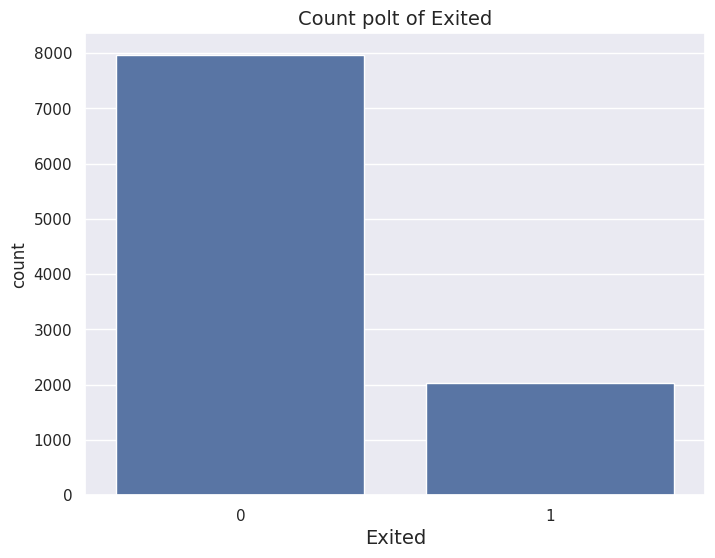

In [57]:
plt.figure(figsize=(8,6))
sns.countplot(data=raw_data,x="Exited")
plt.title("Count polt of Exited",fontsize=14)
plt.xlabel("Exited",fontsize=14)
plt.ylabel("count")
plt.xticks([0,1],label=["not Exited", "Exited"])
plt.show()

# this data is imbalanced

The plot confirms a significant class imbalance. A standard model will likely be biased towards the majority class ('Not Exited'), failing to identify churners effectively.

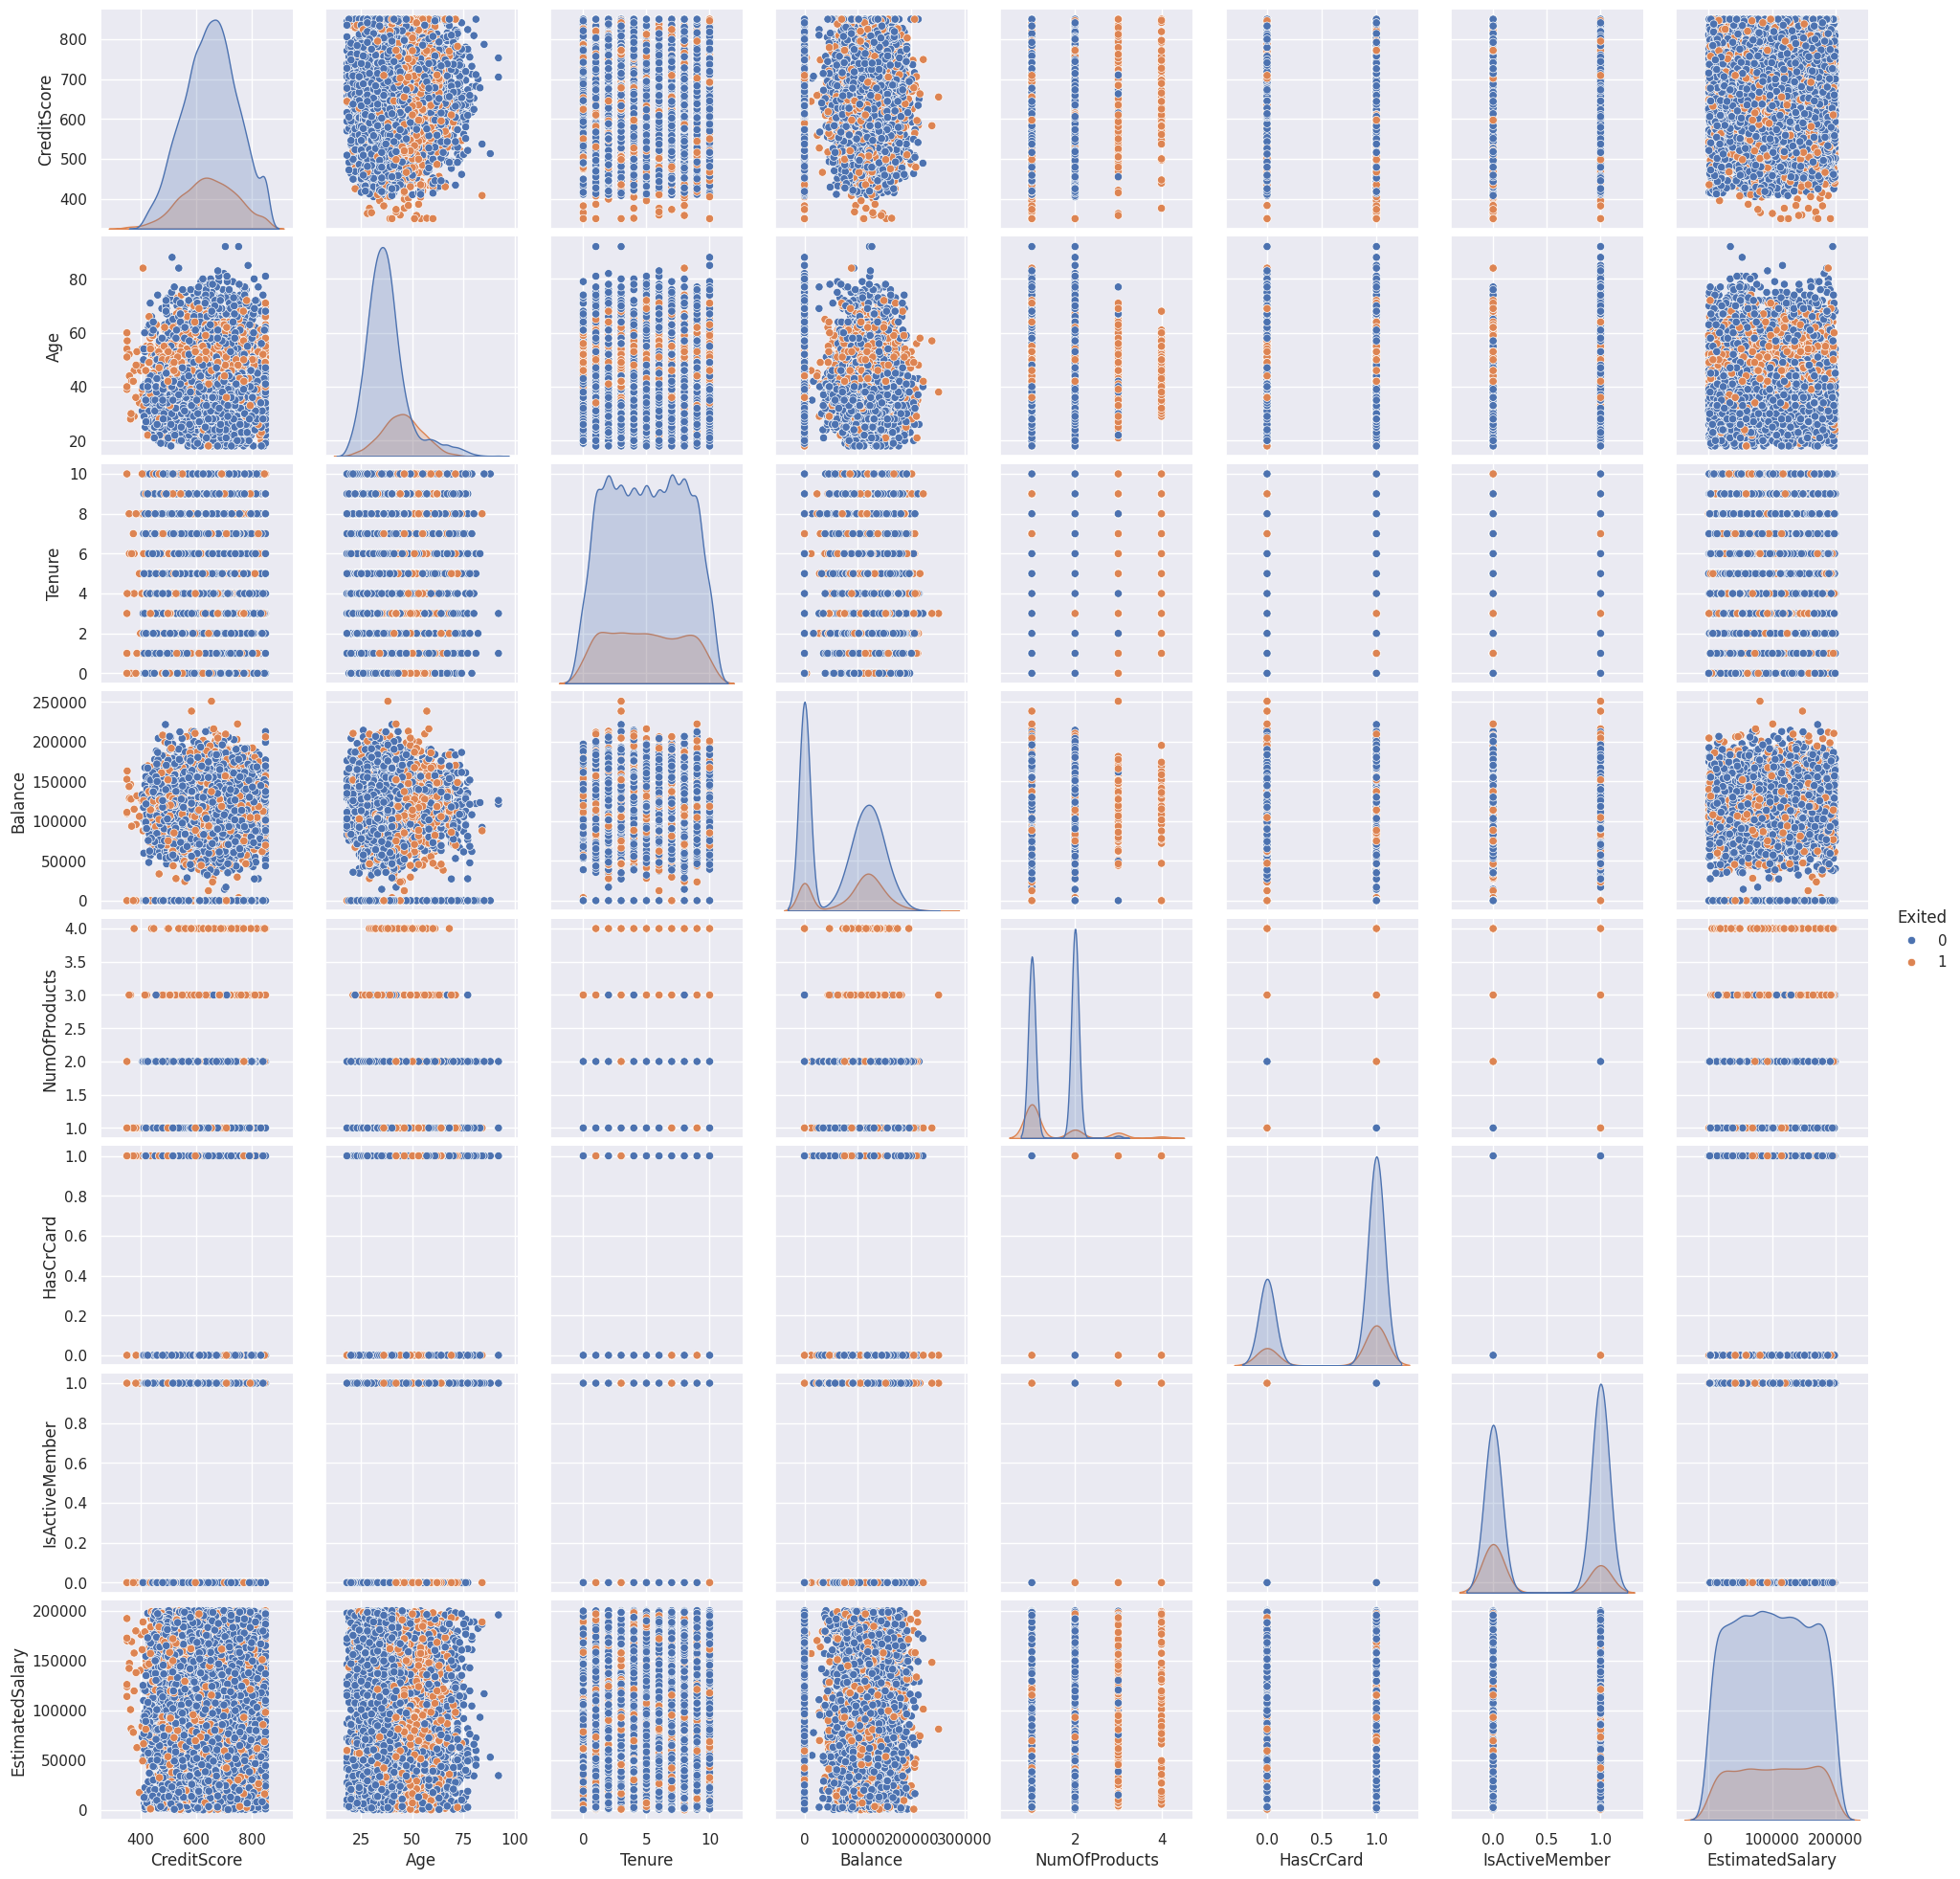

In [58]:
raw_data_a=raw_data[["CreditScore","Geography","Gender","Age","Tenure","Balance","NumOfProducts","HasCrCard","IsActiveMember","EstimatedSalary","Exited"]]
p=sns.pairplot(raw_data_a,hue="Exited")

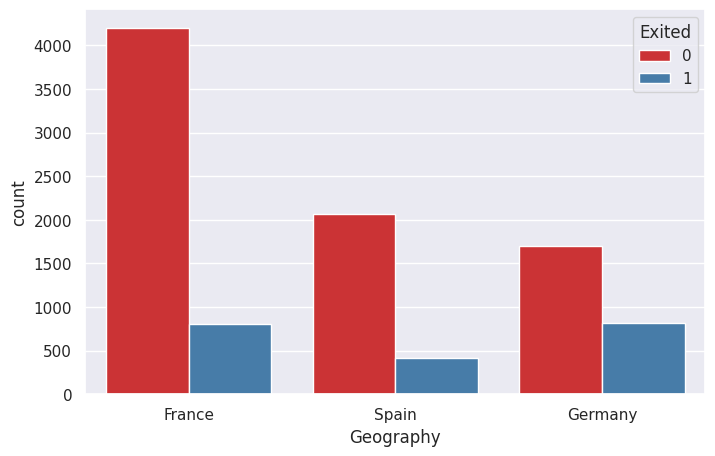

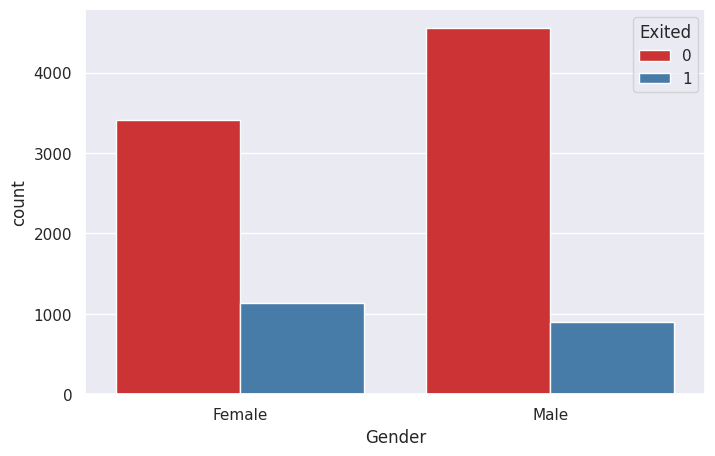

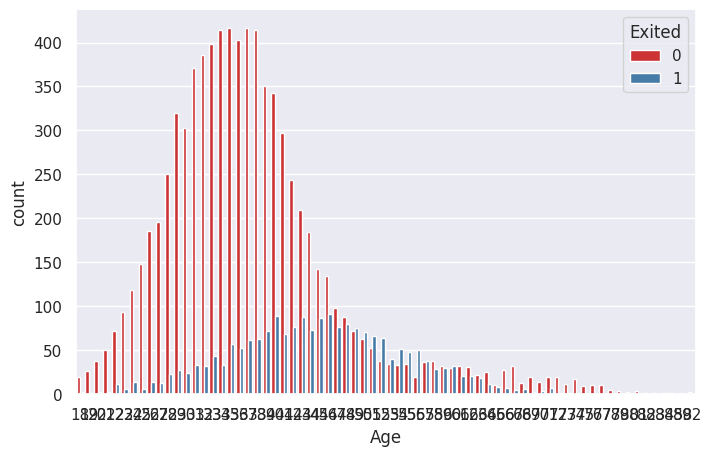

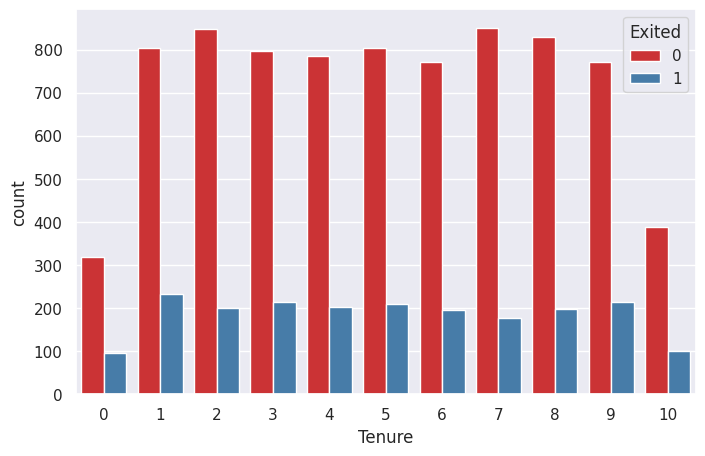

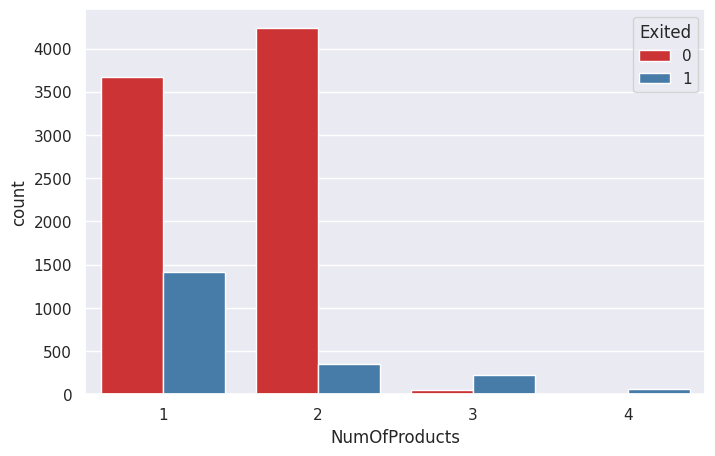

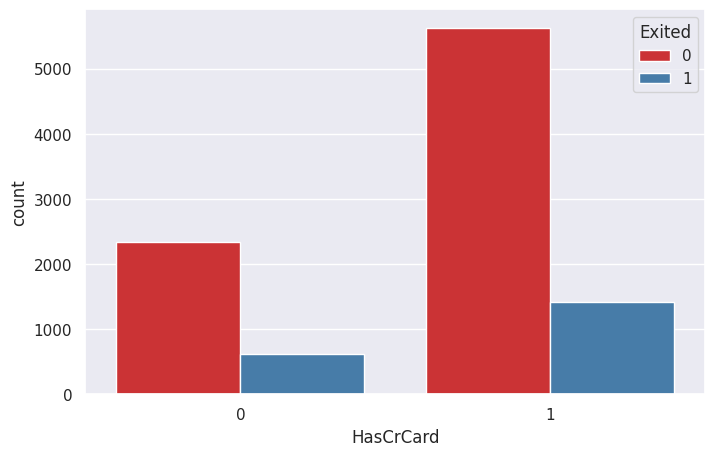

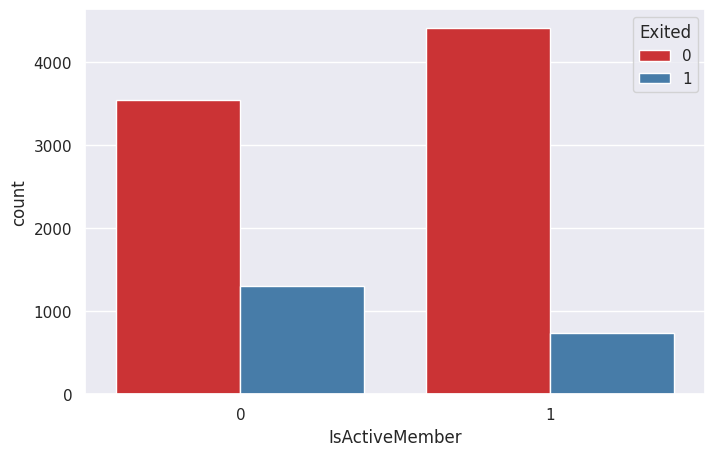

In [59]:
features=["Geography","Gender","Age","Tenure","NumOfProducts","HasCrCard","IsActiveMember"]
for f in features:
    plt.figure()
    ax=sns.countplot(x=f,data=raw_data_a,hue="Exited",palette="Set1")

the median: 652.0


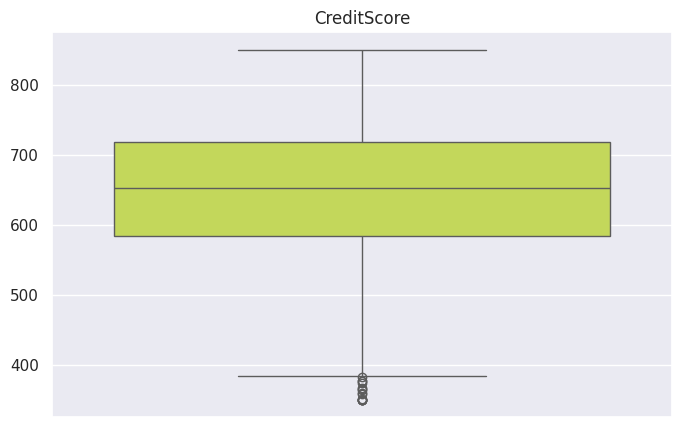

the median: 37.0


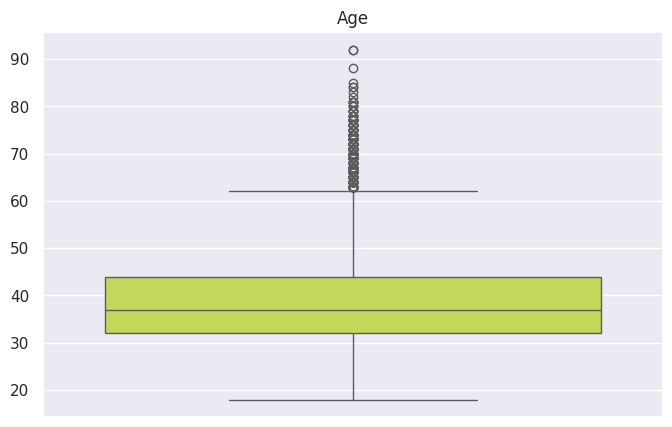

the median: 5.0


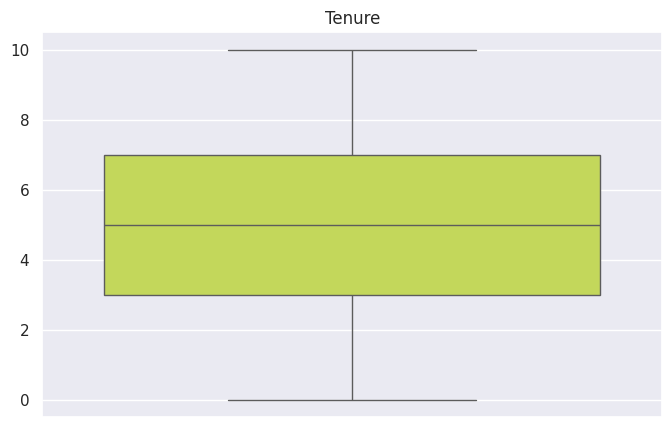

the median: 97198.54000000001


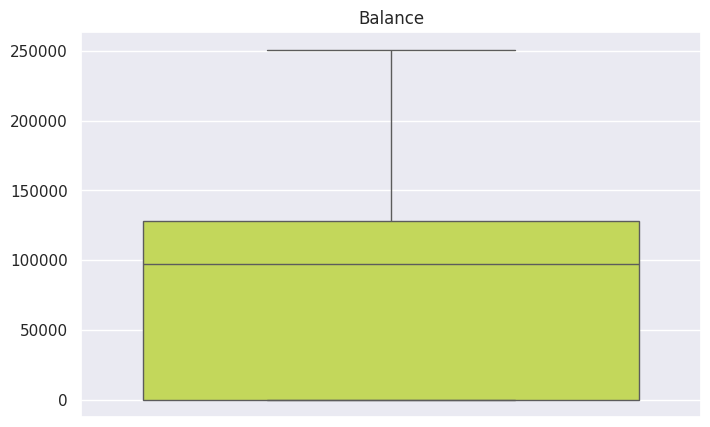

the median: 1.0


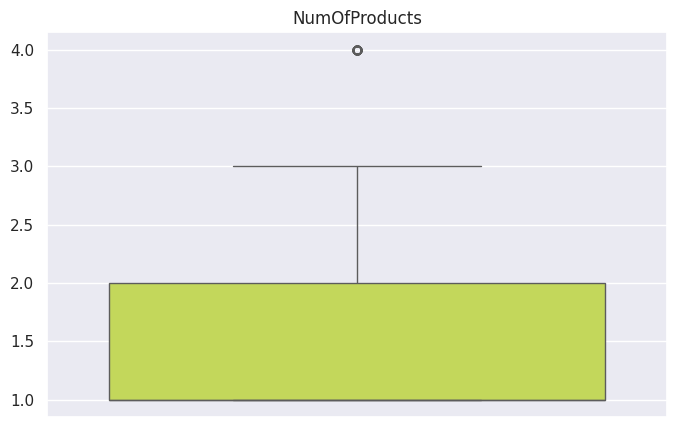

the median: 1.0


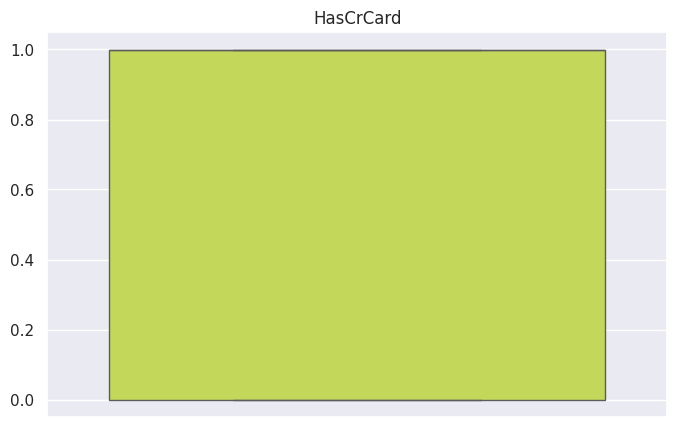

the median: 1.0


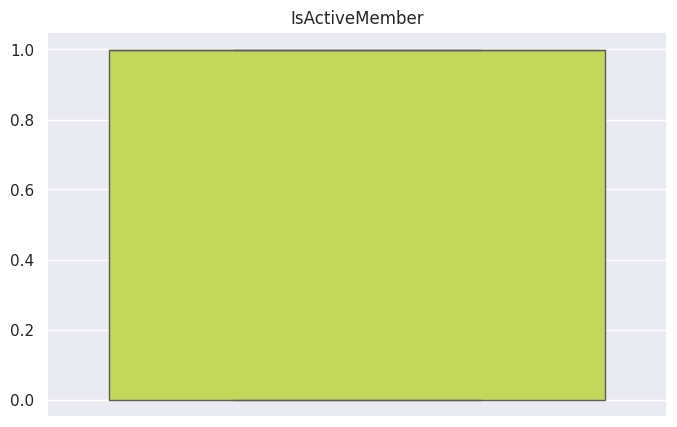

the median: 100193.915


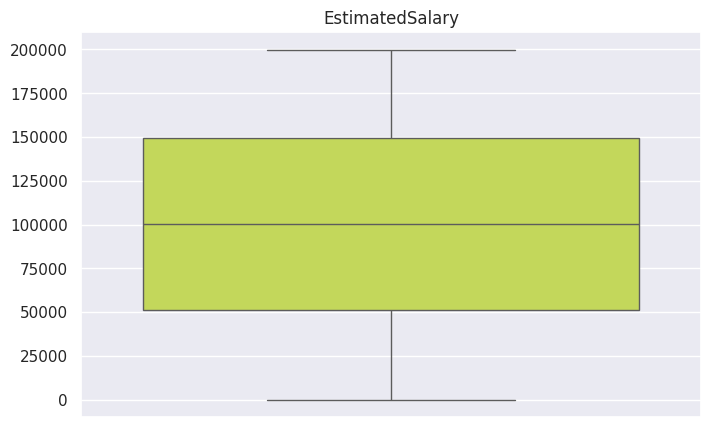

the median: 0.0


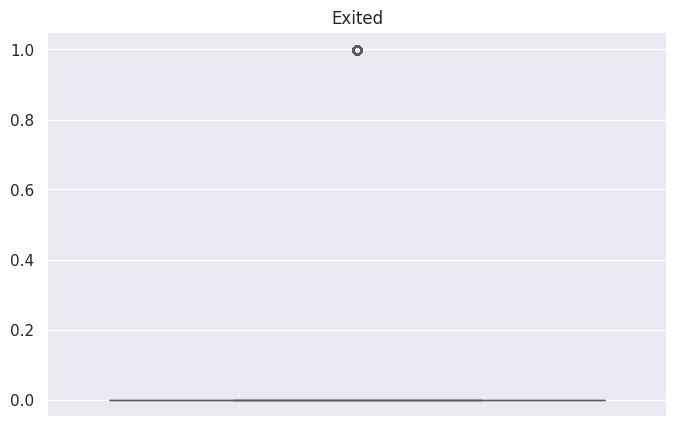

In [60]:
numeric=["int16","int32","int64","float16","float32","float64"]
n_veriable=raw_data_a.select_dtypes(include=numeric).columns
sns.set(rc={"figure.figsize":(8,5)})
for c in n_veriable:
    x=raw_data_a[c].values
    ax=sns.boxplot(x,color="#D1EC46")
    print("the median:",raw_data_a[c].median())
    plt.title(c)
    plt.show()

In [61]:
# Convert categorical string columns into a numerical format.
new_raw_data=pd.get_dummies(raw_data_a,columns=["Geography","Gender","HasCrCard","IsActiveMember"])

# Scale numerical features to a common range (0-1) to ensure all features contribute fairly.
scale_vars=["CreditScore","EstimatedSalary","Tenure","Balance","Age","NumOfProducts"]
scaler=MinMaxScaler()
new_raw_data[scale_vars]=scaler.fit_transform(new_raw_data[scale_vars])
new_raw_data.head(10)

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1
0,0.538,0.324324,0.2,0.000000,0.000000,0.506735,1,True,False,False,True,False,False,True,False,True
1,0.516,0.310811,0.1,0.334031,0.000000,0.562709,0,False,False,True,True,False,True,False,False,True
2,0.304,0.324324,0.8,0.636357,0.666667,0.569654,1,True,False,False,True,False,False,True,True,False
3,0.698,0.283784,0.1,0.000000,0.333333,0.469120,0,True,False,False,True,False,True,False,True,False
4,1.000,0.337838,0.2,0.500246,0.000000,0.395400,0,False,False,True,True,False,False,True,False,True
5,0.590,0.351351,0.8,0.453394,0.333333,0.748797,1,False,False,True,False,True,False,True,True,False
6,0.944,0.432432,0.7,0.000000,0.333333,0.050261,0,True,False,False,False,True,False,True,False,True
7,0.052,0.148649,0.4,0.458540,1.000000,0.596733,1,False,True,False,True,False,False,True,True,False
8,0.302,0.351351,0.4,0.566170,0.333333,0.374680,0,True,False,False,False,True,True,False,False,True
9,0.668,0.121622,0.2,0.536488,0.000000,0.358605,0,True,False,False,False,True,False,True,False,True


# Baseline XGboost model

Training Accuracy: 0.96
Testing Accuracy: 0.86


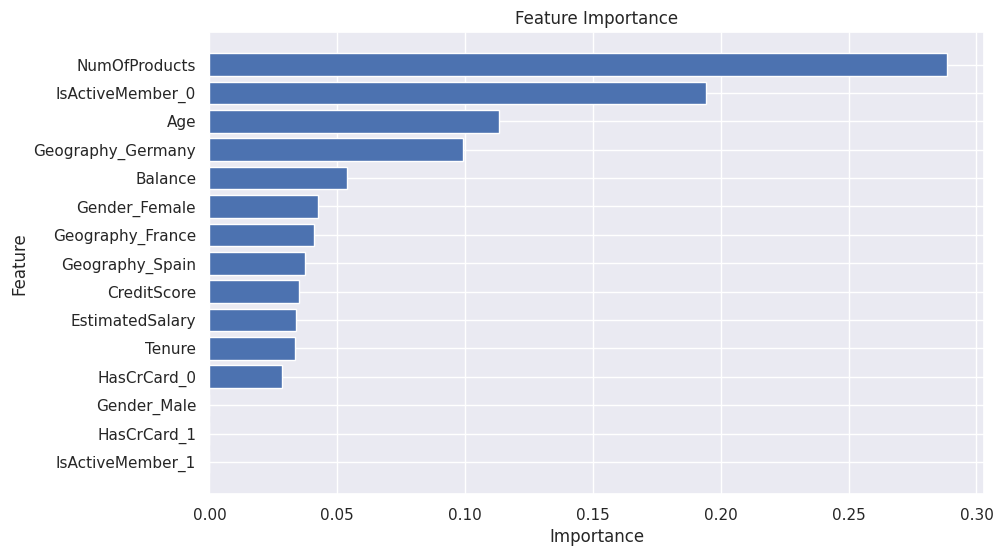


Feature Importance:


,Feature,Importance
4,NumOfProducts,0.288658
13,IsActiveMember_0,0.194039
1,Age,0.113240
7,Geography_Germany,0.099048
3,Balance,0.053883
9,Gender_Female,0.042302
6,Geography_France,0.041067
8,Geography_Spain,0.037478
0,CreditScore,0.034965
5,EstimatedSalary,0.033707


In [62]:
# Features (X) and Target (y)
X = new_raw_data.drop(columns=["Exited"])
y = new_raw_data["Exited"]

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
# This initial model is trained on the imbalanced data to establish a benchmark.
model = XGBClassifier(eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Training and Testing Accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

# Feature Importance
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], align="center")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

# Displaying feature importance
print("\nFeature Importance:")
feature_importance

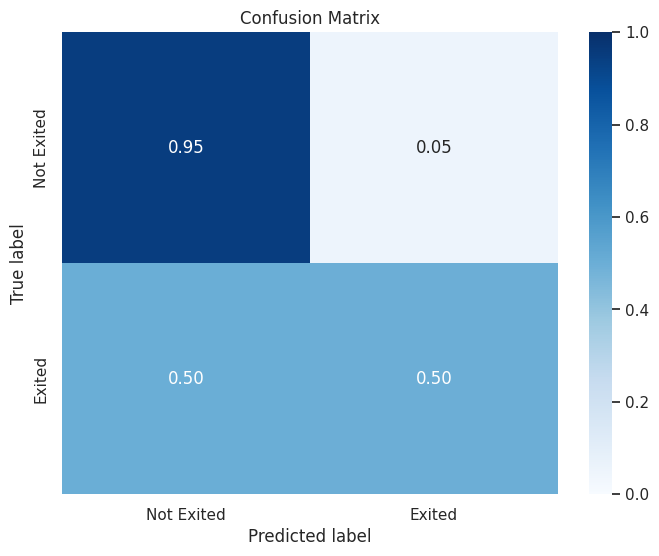

In [63]:
# Confusion Matrix function
def plot_confusion_matrix(cm, classes=None, title='Confusion Matrix'):
    """Plots a confusion matrix."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0, vmax=1, annot=True, cmap="Blues", fmt='.2f')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred, normalize='true')
plot_confusion_matrix(cm, classes=["Not Exited", "Exited"])

Result: The baseline model shows poor recall for the 'Exited' class, confirming the negative effect of the imbalance.

#Visualizing a Simple Decision Tree

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


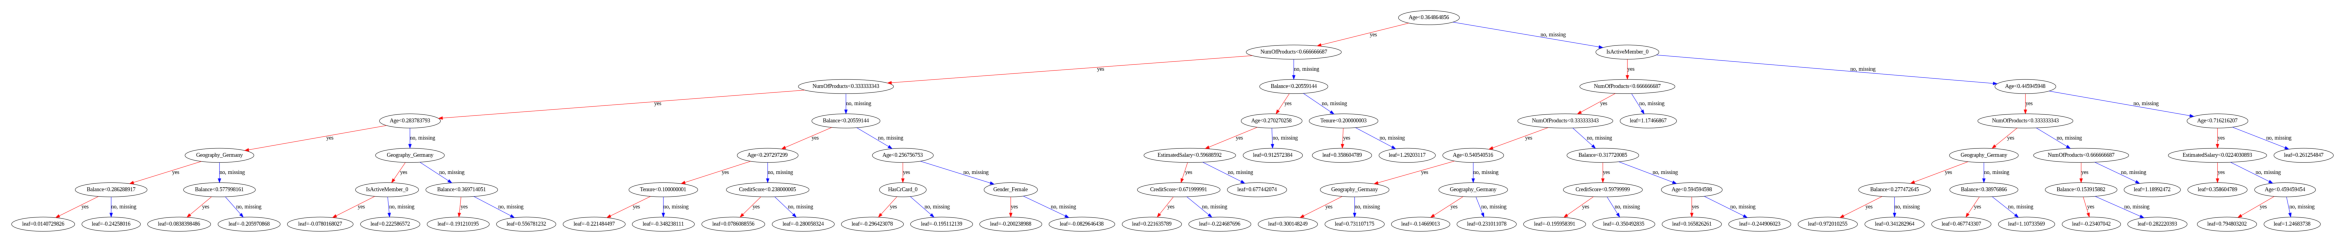

In [64]:
import xgboost as xgb
from PIL import Image

# Export the first tree in the ensemble to DOT format
dot_data = xgb.to_graphviz(model, num_trees=0)

# Save and display the tree
output_file = "xgboost_tree"
dot_data.render(output_file, format="png", view=False)  # Saves 'xgboost_tree.png'

# Display the tree image using PIL (for inline visualization in Jupyter or Python)
img = Image.open(f"{output_file}.png")
plt.figure(figsize=(30, 30))
plt.imshow(img)
plt.axis("off")
plt.show()

Training Accuracy: 0.85
Testing Accuracy: 0.85


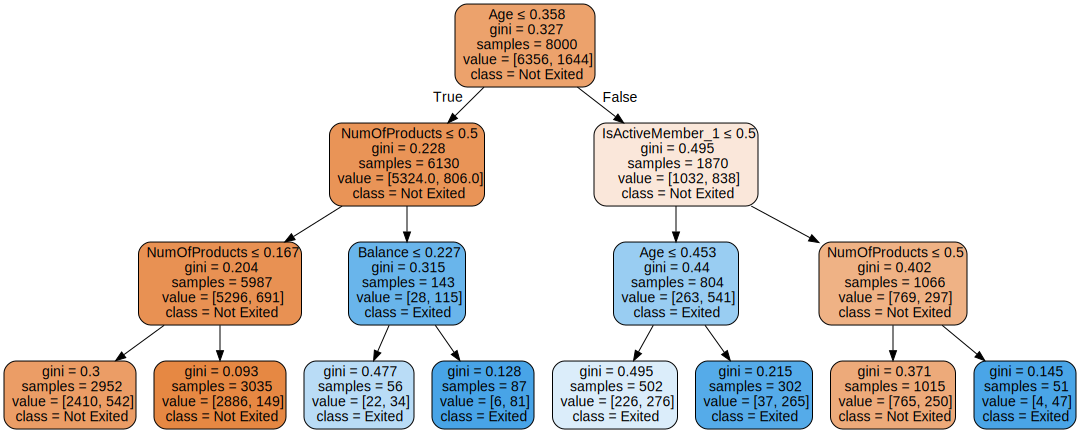

In [65]:
# Tree visual is not easy to read so we will train a simple DT to visual the tree:

from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

# Train a Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42, max_depth=3)  # Adjust max_depth for simplicity
dt.fit(X_train, y_train)

# Predictions and evaluation
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

# Export the decision tree to DOT format
dot_data = export_graphviz(
    dt,
    out_file=None,
    feature_names=new_raw_data.drop("Exited", axis=1).columns,
    class_names=["Not Exited", "Exited"],
    filled=True,
    rounded=True,
    special_characters=True
)

# Visualize the tree using Graphviz
graph = graphviz.Source(dot_data)
graph

# Comparative Analysis of Imbalance Handling Techniques

Experiment A:Resampling with SMOTE




Training Accuracy: 0.97
Testing Accuracy: 0.85


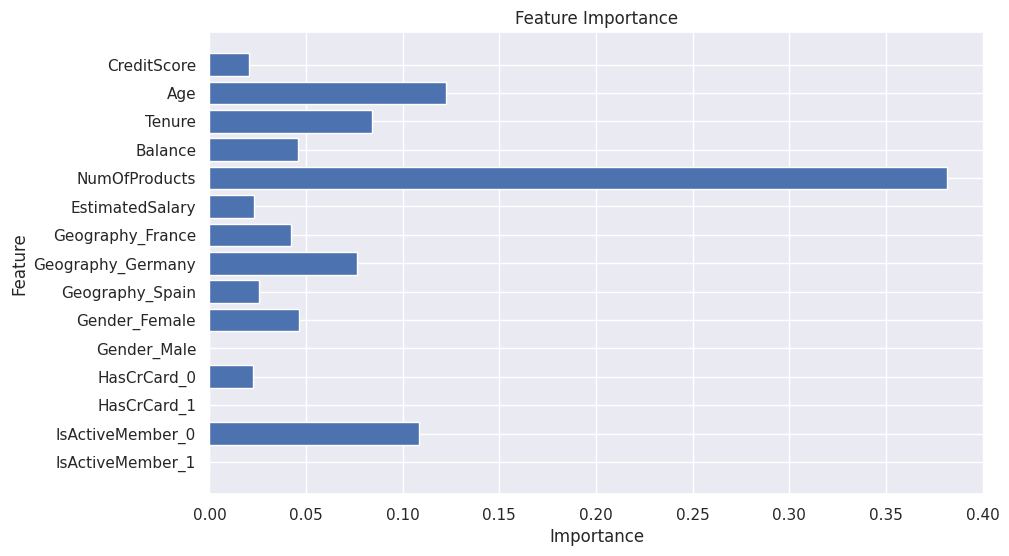

In [66]:
# Re-Running XGBoost using SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Applying SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize the XGBoost classifier
model = XGBClassifier( eval_metric='logloss', random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Predictions
y_train_pred = model.predict(X_train_resampled)
y_test_pred = model.predict(X_test)

# Training and Testing Accuracy
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

# Plotting Feature Importance
feature_importance = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, feature_importance, align='center')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.show()

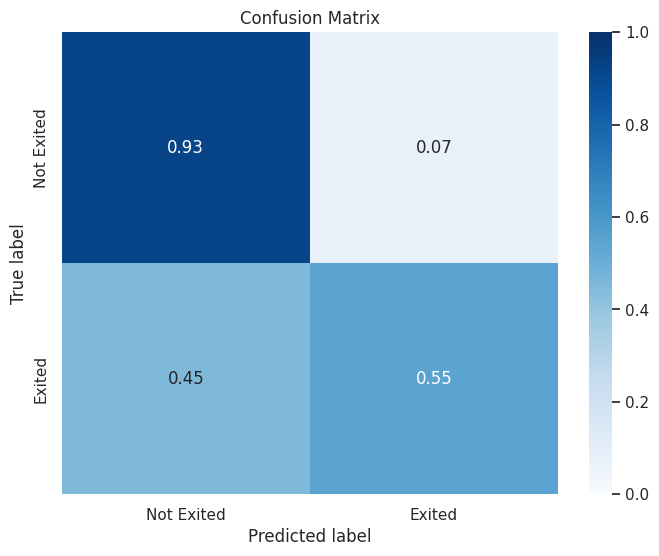

In [67]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred, normalize='true')
plot_confusion_matrix(cm, classes=["Not Exited", "Exited"])

Experiment B: scale_pos_weight

Calculated scale_pos_weight: 3.91



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:45:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix for XGBoost with Class Weighting:


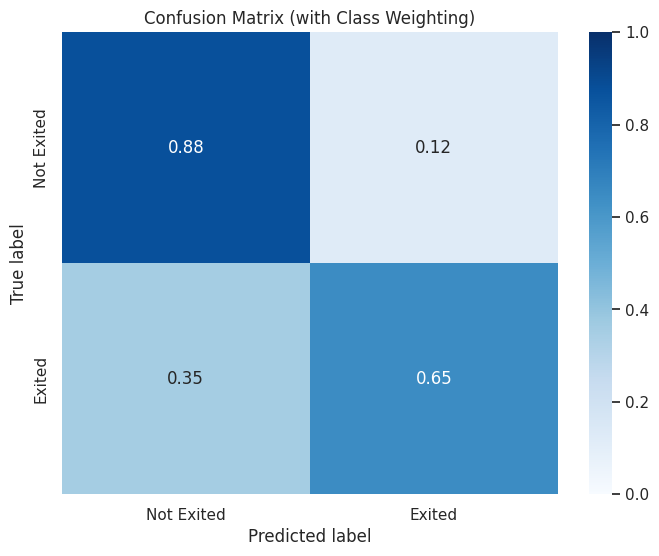

In [68]:
# Re-Running XGBoost with Class Weighting (scale_pos_weight)

# --- 1. Calculate the scale_pos_weight value ---
# This should be done on original target variable 'y' before splitting
scale_pos_weight_value = y.value_counts()[0] / y.value_counts()[1]
print(f"Calculated scale_pos_weight: {scale_pos_weight_value:.2f}\n")

# --- 2. Initialize and Train the XGBoost model ---
# We use the original (un-resampled) training data: X_train, y_train
model_weighted = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight_value,  # The key parameter
    random_state=42
)

model_weighted.fit(X_train, y_train)

# --- 3. Make Predictions and Evaluate ---
y_test_pred_weighted = model_weighted.predict(X_test)

# Calculate and plot the new confusion matrix
print("Confusion Matrix for XGBoost with Class Weighting:")
cm_weighted = confusion_matrix(y_test, y_test_pred_weighted, normalize='true')
plot_confusion_matrix(cm_weighted, classes=["Not Exited", "Exited"], title="Confusion Matrix (with Class Weighting)")

Experiment C: Advanced Ensembling
Testing a Voting Ensemble

A final experiment to see if combining models could yield further improvements.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:45:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix for the Ensemble Model:


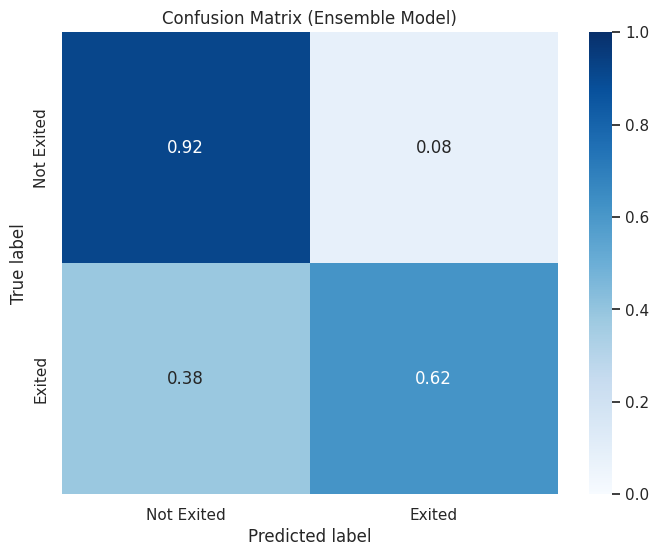

In [69]:
# Building an Ensemble Model (Voting Classifier)
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# --- 1. Initialize the individual models ---

# We'll use parameters to help each model handle the class imbalance
scale_pos_weight_value = y.value_counts()[0] / y.value_counts()[1] # From your previous step

# Model 1: Logistic Regression
clf1 = LogisticRegression(
    random_state=42,
    class_weight='balanced', # Helps with imbalance
    solver='liblinear'
)

# Model 2: Random Forest
clf2 = RandomForestClassifier(
    random_state=42,
    class_weight='balanced' # Helps with imbalance
)

# Model 3: Your best XGBoost model
clf3 = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight_value,
    random_state=42
)


# --- 2. Create the Ensemble Voting Classifier ---
# We use 'soft' voting to average the predicted probabilities, which is often more powerful
ensemble_model = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('xgb', clf3)],
    voting='soft'
)


# --- 3. Train the Ensemble Model ---
# We train on the original (un-resampled) training data
ensemble_model.fit(X_train, y_train)


# --- 4. Make Predictions and Evaluate ---
y_test_pred_ensemble = ensemble_model.predict(X_test)

# Calculate and plot the new confusion matrix for the ensemble
print("Confusion Matrix for the Ensemble Model:")
cm_ensemble = confusion_matrix(y_test, y_test_pred_ensemble, normalize='true')
plot_confusion_matrix(cm_ensemble, classes=["Not Exited", "Exited"], title="Confusion Matrix (Ensemble Model)")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:45:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:45:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:45:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:45:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:45:49] WARNING: /w

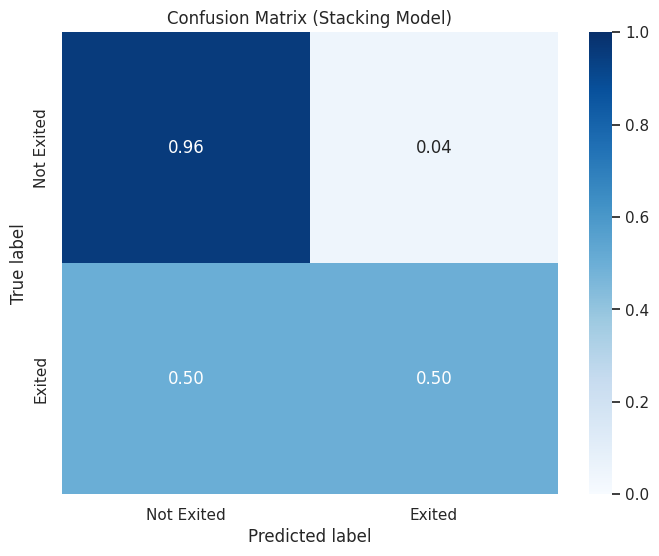

In [70]:

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Your base models (estimators) are the same as before
estimators = [
    ('lr', clf1),
    ('rf', clf2),
    ('xgb', clf3)
]

# The meta-model learns to combine the base model predictions
# Logistic Regression is a common choice for the final_estimator
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression()
)

# Fit and evaluate the stacking model
stacking_model.fit(X_train, y_train)
y_pred_stacking = stacking_model.predict(X_test)

# Check the confusion matrix for the stacking model
cm_stacking = confusion_matrix(y_test, y_pred_stacking, normalize='true')

# Corrected function call:
plot_confusion_matrix(
    cm_stacking,
    classes=["Not Exited", "Exited"],
    title="Confusion Matrix (Stacking Model)"
)

# # Hyperparameter Tuning the Champion Model

In [71]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

print("--- Starting Hyperparameter Tuning for the Weighted Model ---")

# 1. Define the Parameter Grid for the Search
# This grid includes a range of values for the most important XGBoost parameters.
# We also include 'scale_pos_weight' to let the tuner find the optimal value.
param_grid = {
    "n_estimators": [100, 200, 300, 400],      # Number of trees in the forest
    "max_depth": [4, 5, 7, 10],            # Maximum depth of a tree
    "learning_rate": [0.01, 0.05, 0.1, 0.2],   # Step size shrinkage
    "subsample": [0.8, 1.0],                   # Fraction of samples used for fitting the trees
    "colsample_bytree": [0.8, 1.0],            # Fraction of features used for fitting the trees
    "gamma": [0, 1, 5],                      # Minimum loss reduction required to make a split
    "scale_pos_weight": [3.5, 3.9, 4.5]      # Let the tuner find the best class weight
}

# 2. Initialize the Base XGBoost Classifier
# We don't need to pass scale_pos_weight here since it's in the grid
xgb_base = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# 3. Set up the Randomized Search with Cross-Validation
# The tuner will try 75 different combinations and optimize for 'recall'.
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=75,          # Number of parameter combinations to try
    scoring="recall",   # The key metric to optimize for
    cv=3,               # 3-fold cross-validation
    random_state=42,
    verbose=1,          # Prints updates during the search
    n_jobs=-1           # Use all available CPU cores
)

# 4. Fit the Randomized Search to the Training Data
# This process will take a few minutes to complete.
random_search.fit(X_train, y_train)

# 5. Get the Best Model and its Parameters
print("\n--- Hyperparameter Tuning Complete ---")

# Print the best combination of parameters found
print("Best Hyperparameters found:", random_search.best_params_)

# Print the best cross-validated recall score
print(f"Best cross-validated recall score: {random_search.best_score_:.2f}")

# Get the final, best-performing model object
best_model = random_search.best_estimator_

--- Starting Hyperparameter Tuning for the Weighted Model ---
Fitting 3 folds for each of 75 candidates, totalling 225 fits

--- Hyperparameter Tuning Complete ---
Best Hyperparameters found: {'subsample': 1.0, 'scale_pos_weight': 4.5, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.8}
Best cross-validated recall score: 0.79


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:47:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Final Champion Model Evaluation ---


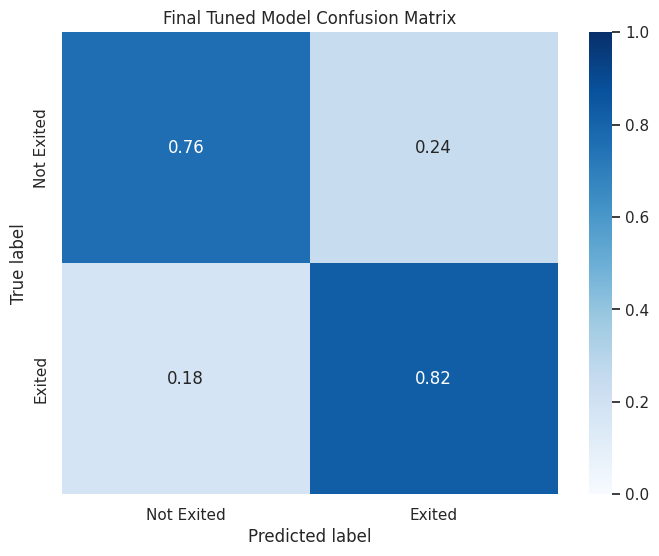

In [72]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\n--- Final Champion Model Evaluation ---")

# 1. Make predictions on the test set using your best model
y_test_pred_final = best_model.predict(X_test)

# 2. Define the reusable Confusion Matrix plotting function
def plot_confusion_matrix(cm, classes=None, title='Confusion Matrix'):
    """Plots a confusion matrix."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0, vmax=1, annot=True, cmap="Blues", fmt='.2f')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# 3. Calculate and plot the final, normalized confusion matrix
# 'normalize='true'' shows the percentage (recall) for each class
cm_final = confusion_matrix(y_test, y_test_pred_final, normalize='true')

plot_confusion_matrix(cm_final, classes=["Not Exited", "Exited"], title="Final Tuned Model Confusion Matrix")


--- Final Champion Model Evaluation ---


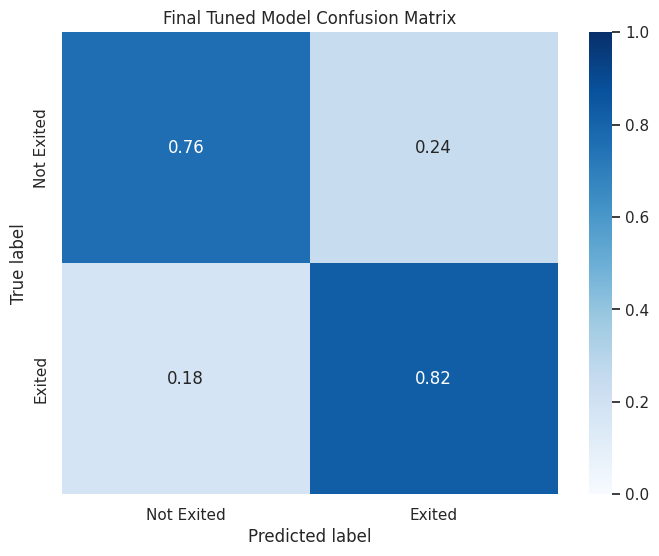


Final Classification Report:
              precision    recall  f1-score   support

  Not Exited       0.95      0.76      0.84      1607
      Exited       0.45      0.82      0.58       393

    accuracy                           0.77      2000
   macro avg       0.70      0.79      0.71      2000
weighted avg       0.85      0.77      0.79      2000


--- Storing Final Feature Importances ---
Final feature importance data exported successfully!

Final Model Feature Importance:
              Feature  Importance  Feature Importance Score
4       NumOfProducts    0.220217                    0.2202
1                 Age    0.203154                    0.2032
14   IsActiveMember_1    0.133495                    0.1335
13   IsActiveMember_0    0.116583                    0.1166
7   Geography_Germany    0.065774                    0.0658

--- Storing Final Predictions ---
Final data with predictions exported successfully!

--- Saving Final Model and Scaler ---
Champion model and scaler sav

In [73]:
# FINAL MODEL EVALUATION
print("\n--- Final Champion Model Evaluation ---")

# Final Predictions and Confusion Matrix
# Make predictions on the test set using your best model from the search
y_test_pred_final = best_model.predict(X_test)

# Define the reusable Confusion Matrix plotting function
def plot_confusion_matrix(cm, classes=None, title='Confusion Matrix'):
    """Plots a normalized confusion matrix."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0, vmax=1, annot=True, cmap="Blues", fmt='.2f')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Calculate and plot the final, normalized confusion matrix
cm_final = confusion_matrix(y_test, y_test_pred_final, normalize='true')
plot_confusion_matrix(cm_final, classes=["Not Exited", "Exited"], title="Final Tuned Model Confusion Matrix")

# --- 7.2. Final Classification Report ---
# Display a detailed report of precision, recall, and f1-score
print("\nFinal Classification Report:")
print(classification_report(y_test, y_test_pred_final, target_names=["Not Exited", "Exited"]))


# FINAL FEATURE IMPORTANCE AND RESULTS

# Create and Store FINAL Feature Importance ---
# This is the corrected step: Create the DataFrame from your BEST model
print("\n--- Storing Final Feature Importances ---")
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": best_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Add a rounded score column for better presentation
feature_importance['Feature Importance Score'] = feature_importance['Importance'].round(4)

# Save the final DataFrame to an Excel file
feature_importance.to_excel("feature_importance.xlsx", index=False)

print("Final feature importance data exported successfully!")
print("\nFinal Model Feature Importance:")
print(feature_importance.head())


# Store Final Predictions ---
print("\n--- Storing Final Predictions ---")
# Make predictions on the entire preprocessed dataset (X)
all_df_predict = best_model.predict(X)
all_df_predict_prob = best_model.predict_proba(X)

# Create a new DataFrame for the results
results_df = new_raw_data.copy()

# Add the prediction and probability columns to this new DataFrame
results_df['Exited_Prediction'] = all_df_predict
results_df['Exited_Probability'] = all_df_predict_prob[:, 1]

# (Optional) Join with original data to get columns like 'Surname'
results_df = raw_data[['CustomerId', 'Surname']].join(results_df)

# Export the final DataFrame with predictions to Excel
results_df.to_excel("bank_churn_predictions.xlsx", index=False)

print("Final data with predictions exported successfully!")


# SAVING THE MODEL ITSELF
print("\n--- Saving Final Model and Scaler ---")
# Save the best_model to a file for the Streamlit app
with open('best_churn_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# Save the scaler object as well
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

print("Champion model and scaler saved successfully!")